## This is the Baseline Models Comparison and Selection

# 1. Load Librares

In [51]:
# this is Jupyter width setting
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

# this is pandas table width setting
pd.set_option('display.expand_frame_repr', False)

# display pd table side by side
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()

# 2. Load the Data

In [2]:
# load train1, test1, rul1 pickle to have a test

train1 = pd.read_pickle('data/train1.pkl')
test1 = pd.read_pickle('data/test1.pkl')
RUL1 = pd.read_pickle('data/RUL1.pkl')

In [3]:
train1[0:1]

,id,cycle,setting1,setting2,setting3,sensor2,sensor3,sensor4,sensor7,sensor8,...,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,rul,w1,w2
0,1,1,-0.0007,-0.0004,100.0,641.82,1589.7,1400.6,554.36,2388.06,...,521.66,2388.02,8138.62,8.4195,392,39.06,23.419,191,0,0


In [4]:
test1[0:1]

,id,cycle,setting1,setting2,setting3,sensor2,sensor3,sensor4,sensor7,sensor8,...,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,truth,rul,w1,w2
0,1,1,0.0023,0.0003,100.0,643.02,1585.29,1398.21,553.9,2388.04,...,2388.03,8125.55,8.4052,392,38.86,23.3735,112,142,0,0


In [5]:
RUL1[0:1]

,truth,id
0,112,1


# 3. Regression (for 'rul')
- linear regression
- LASSO
- ridge regression
- decision tree regression
- random forest regression

In [6]:
# train/test data definition

X_train, Y_train = train1.iloc[:,2:19], train1.iloc[:,19:20]
X_test, Y_test = test1.iloc[:,2:19], test1.iloc[:,20:21]

### 3.A Regression Support Functions

In [7]:
# define regression metrics calculation

from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn import metrics
def get_regression_metrics(model_name, model, x_train, y_train, x_test, y_test):
    '''Calculate regression performance metrics
    model_name (str):      model name
    model (clf):           model
    x_train:               training set
    y_train:               training label
    x_test:                testing set
    y_test (series):       testing label
    y_pred (series):       predict value will be generated within function
    returns:               combined metrics in a dataframe
    '''
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    regression_metrics = {
        'explained variance':      metrics.explained_variance_score(y_test, y_pred),
        'root mean squared error': metrics.mean_squared_error(y_test, y_pred)**0.5,
        'mean absolute error':     metrics.mean_absolute_error(y_test, y_pred),
        'r2 score':                metrics.r2_score(y_test, y_pred)    }
    df_regression_metrics = pd.DataFrame.from_dict(regression_metrics, orient='index')
    df_regression_metrics.columns = [model_name]
    return df_regression_metrics

In [8]:
# define feature importance plot

def plot_feature_importance(model_name, model, x_train, y_train):
    '''Plot regression feature importance (coefficients weights)
    model (str):           model name
    weights (array):       coefficient weights
    f_names (list):        feature names
    weight_type (str):     'c' for coefficient weights, o.w. is feature importance
    returns:               plt of feature importance (coefficient weights)
    '''
    model.fit(x_train, y_train.values.ravel())
    if model_name == 'DecisionTr' or model_name == 'RandomFore':
        W = pd.DataFrame({'weights': model.feature_importances_}, x_train.columns)
    else:
        W = pd.DataFrame({'weights': model.coef_}, x_train.columns)        
    W.sort_values(by='weights', ascending=True).plot(kind='barh', color='r', figsize=(8, 3))
    label = ' feature importance' if (model_name == 'DecisionTr' or model_name == 'RandomFore') else ' coefficients'
    plt.xlabel(model_name + label)
    plt.grid(color='gray', linewidth=0.15, linestyle='-.')
    plt.show()

### 3.B Load Models

In [9]:
# linear regression
from sklearn import linear_model
lin_regr = linear_model.LinearRegression()

# LASSO regression
lasso_regr = linear_model.Lasso(alpha=0.001)

# ridge regression
rd_regr = linear_model.Ridge(alpha=0.01)

# decision tree regression
from sklearn.tree import DecisionTreeRegressor
dtr_regr = DecisionTreeRegressor(max_depth=7, random_state=123)

# random forest regression
from sklearn.ensemble import RandomForestRegressor
rf_regr = RandomForestRegressor(n_estimators=100, max_features=3, max_depth=4, n_jobs=-1, random_state=1)

# list of (models (clf), model names (str))
list_reg_model_name = [(str(m).split('(')[0][0:10], m) for m in [lin_regr, lasso_regr, rd_regr, dtr_regr, rf_regr]]

### 3.C Compare Model Performance

In [10]:
# compare performance metrics

newDF = pd.DataFrame(index=['root mean squared error','mean absolute error','explained variance','r2 score'])
for name, model in list_reg_model_name:
    newDF = pd.concat([newDF, get_regression_metrics(name, model, X_train, Y_train, X_test, Y_test)], axis=1)
newDF

,LinearRegr,Lasso,Ridge,DecisionTr,RandomFore
explained variance,0.337138,0.337516,0.337424,0.339755,0.351758
mean absolute error,37.163542,37.151975,37.154635,36.353867,36.766395
r2 score,0.327030,0.327385,0.327301,0.335055,0.330541
root mean squared error,48.382349,48.369585,48.372582,48.093018,48.255980


### 3.D Feature Importance Review

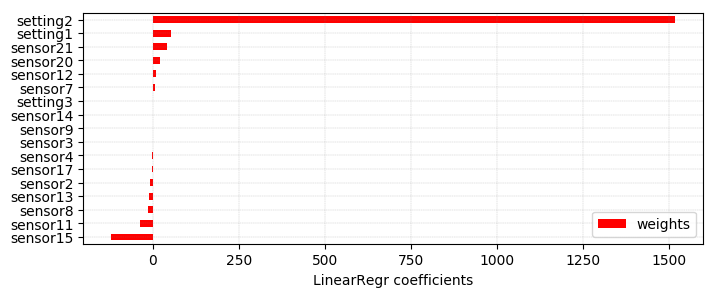

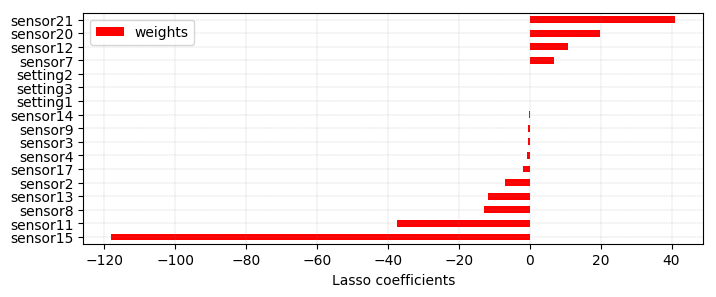

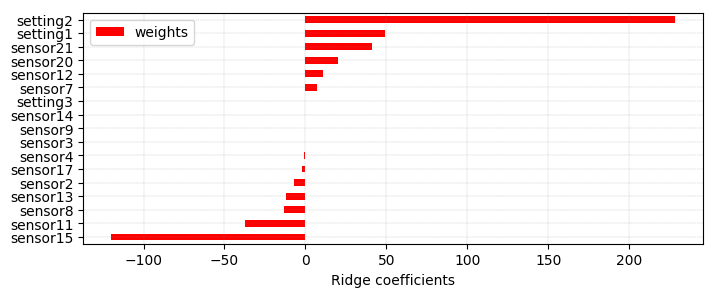

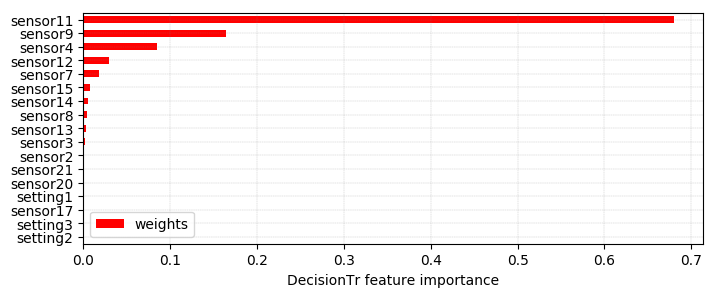

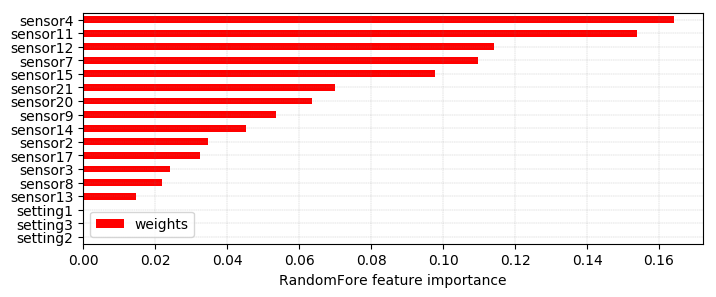

[None, None, None, None, None]

In [11]:
# Review all feature importance or coefficiency

[plot_feature_importance(name, model, X_train, Y_train) for name, model in list_reg_model_name]

### 3.E Regression Baseline Summary
- Using default features, model errors are high and performance not good
- Insights:
    - Understood the regression model performance under raw data
    - Understood the feature importance under each model
    - Gain a baseline though its performance is poor, but leave room for improvement
- Next steps:
    - Feature engineering
    - Hyper-parameter tuning (Grid search)
    - Based on these to refine the model and select best performer

# 4. Binary Classifications
- logistic regression
- decision tree
- random forest
- support vector machine
- k nearest neighbor

In [12]:
# train/test data definition for binary

X_train_b, Y_train_b = train1.iloc[:,2:19], train1.iloc[:,20:21]
X_test_b, Y_test_b = test1.iloc[:,2:19], test1.iloc[:,21:22]

### 4.A Binary Classification Support Functions

In [13]:
# define binary metrics calculation

from sklearn import metrics
def get_binary_metrics(model_name, model, x_train, y_train, x_test, y_test):
    '''Calculate binary classification performance metrics
    model_name (str):      model name
    model (clf):           model
    x_train:               training set
    y_train:               training label
    x_test:                testing set
    y_test (series):       testing label
    y_pred (series):       predict value will be generated within function
    returns:               combined metrics in a dataframe
    '''
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    binary_metrics = {
        'accuracy':                metrics.accuracy_score(y_test, y_pred),
        'Precision':               metrics.precision_score(y_test, y_pred),
        'Recall':                  metrics.recall_score(y_test, y_pred),
        'f1 score':                metrics.f1_score(y_test, y_pred)   }
    df_binary_metrics = pd.DataFrame.from_dict(binary_metrics, orient='index')
    df_binary_metrics.columns = [model_name]
    return df_binary_metrics

### 4.B Load Models

In [14]:
# logistic regression
from sklearn.linear_model import LogisticRegression
clf_lg_b = LogisticRegression(random_state=123)

# decision trees
from sklearn.tree import DecisionTreeClassifier, export_graphviz
clf_dt_b = DecisionTreeClassifier(random_state=123)

# random forest
from sklearn.ensemble import RandomForestClassifier
clf_rf_b = RandomForestClassifier(n_estimators=50, random_state=123)

# support vector machine
from sklearn.svm import SVC
clf_svc_b = SVC(kernel='rbf', random_state=123)

# k nearest neighbor
from sklearn.neighbors import KNeighborsClassifier
clf_knn_b = KNeighborsClassifier(n_jobs=-1)

# list of (models (clf), model names (str))
list_bin_model_name = [(str(m).split('(')[0][0:10], m) for m in [clf_lg_b, clf_dt_b, clf_rf_b, clf_svc_b, clf_knn_b]]

### 4.C Compare Model Performance

In [19]:
# compare performance metrics

newDF_bin = pd.DataFrame(index=['accuracy','Precision','Recall', 'f1 score'])
for name, model in list_bin_model_name:
    newDF_bin = pd.concat([newDF_bin, get_binary_metrics(name, model, X_train_b, Y_train_b, X_test_b, Y_test_b)], axis=1)
newDF_bin

,LogisticRe,DecisionTr,RandomFore,SVC,KNeighbors
accuracy,0.983201,0.976405,0.986714,0.983735,0.981139
Precision,0.745614,0.532764,0.829167,0.753191,0.657993
Recall,0.512048,0.563253,0.599398,0.533133,0.533133
f1 score,0.607143,0.547584,0.695804,0.624339,0.589018


### 4.E Binary Classification Summary
- Accuracy for binary classification is better than regression
- Insights:
    - RandomForest model looks better performance
- Next Step:
    - Feature Engineering
    - hyper-parameter tuning (Grid search)

# 5. Multi-Class Classifications
- logistic regression
- decision tree
- random forest
- support vector machine (linear svc)
- k nearest neigbor (knn)
- neural network (MLP multi-layer perceptron)

In [22]:
# train/test data definition for multi-class

X_train_m, Y_train_m = train1.iloc[:,2:19], train1.iloc[:,21:22]
X_test_m, Y_test_m = test1.iloc[:,2:19], test1.iloc[:,22:23]

### 5.A Multi-Class Classification Support Functions

In [29]:
# define multi-class metrics calculation

from sklearn import metrics
def get_multi_metrics(model_name, model, x_train, y_train, x_test, y_test):
    '''Calculate multi-class classification performance metrics
    model_name (str):      model name
    model (clf):           model
    x_train:               training set
    y_train:               training label
    x_test:                testing set
    y_test (series):       testing label
    y_pred (series):       predict value will be generated within function
    returns:               combined metrics in a dataframe
    '''
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    multi_metrics = {
        'accuracy':                metrics.accuracy_score(y_test, y_pred),
        'macro F1':                metrics.f1_score(y_test, y_pred, average='macro'),
        'micro F1':                metrics.f1_score(y_test, y_pred, average='micro'),
        'macro Precision':         metrics.precision_score(y_test, y_pred,  average='macro'),
        'micro Precision':         metrics.precision_score(y_test, y_pred,  average='micro'),
        'macro Recall':            metrics.recall_score(y_test, y_pred,  average='macro'),
        'micro Recall':            metrics.recall_score(y_test, y_pred,  average='micro')   }
    df_multi_metrics = pd.DataFrame.from_dict(multi_metrics, orient='index')
    df_multi_metrics.columns = [model_name]
    return df_multi_metrics

### 5.B Load Models

In [42]:
# logistic regression
from sklearn.linear_model import LogisticRegression
clf_lg_m = LogisticRegression(random_state=123)

# decision trees
from sklearn.tree import DecisionTreeClassifier, export_graphviz
clf_dt_m = DecisionTreeClassifier(random_state=123)

# random forest
from sklearn.ensemble import RandomForestClassifier
clf_rf_m = RandomForestClassifier(n_estimators=50, random_state=123)

# support vector machine
from sklearn.svm import SVC
clf_svc_m = SVC(kernel='rbf', random_state=123)

# k nearest neighbor
from sklearn.neighbors import KNeighborsClassifier
clf_knn_m = KNeighborsClassifier(n_jobs=-1)

# neural network
from sklearn.neural_network import MLPClassifier
clf_nn_m = MLPClassifier(random_state=123)

# list of (models (clf), model names (str))
list_multi_model_name = [(str(m).split('(')[0][0:10], m) for m in [clf_lg_m, clf_dt_m, clf_rf_m, clf_svc_m, clf_knn_m, clf_nn_m]]

### 5.C Compare Model Performance

In [43]:
# compare performance metrics
# too few data caused some warnings, ignore it

newDF_mul = pd.DataFrame(index=['accuracy','macro F1','micro F1','macro Precision','micro Precision','macro Recall','micro Recall'])
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for name, model in list_multi_model_name:
        newDF_mul = pd.concat([newDF_mul, get_multi_metrics(name, model, X_train_m, Y_train_m, X_test_m, Y_test_m)], axis=1)
newDF_mul

,LogisticRe,DecisionTr,RandomFore,SVC,KNeighbors,MLPClassif
accuracy,0.976710,0.975489,0.983201,0.978619,0.977474,0.974649
macro F1,0.489040,0.633160,0.718793,0.591133,0.606923,0.329054
macro Precision,0.778457,0.615023,0.788519,0.657734,0.645569,0.324883
macro Recall,0.567474,0.665344,0.670847,0.569406,0.587005,0.333333
micro F1,0.976710,0.975489,0.983201,0.978619,0.977474,0.974649
micro Precision,0.976710,0.975489,0.983201,0.978619,0.977474,0.974649
micro Recall,0.976710,0.975489,0.983201,0.978619,0.977474,0.974649


### 5.D Multi-Class Classification Insights
- On raw data, Random forest performs strong among all classifiers
- Next step:
    - Feature engineering
    - hyper-parameter tuning (Grid search)
    - Compare the performance again

# 6. Review of All Models

In [64]:
# gives a simple review of all models under each predictions

print('regressions', '\n', newDF, '\n')
print('binary classifications', '\n',newDF_bin, '\n')
print('multi-class classifications', '\n',newDF_mul)

regressions 
                          LinearRegr      Lasso      Ridge  DecisionTr  RandomFore
explained variance         0.337138   0.337516   0.337424    0.339755    0.351758
mean absolute error       37.163542  37.151975  37.154635   36.353867   36.766395
r2 score                   0.327030   0.327385   0.327301    0.335055    0.330541
root mean squared error   48.382349  48.369585  48.372582   48.093018   48.255980 

binary classifications 
            LogisticRe  DecisionTr  RandomFore       SVC  KNeighbors
accuracy     0.983201    0.976405    0.986714  0.983735    0.981139
Precision    0.745614    0.532764    0.829167  0.753191    0.657993
Recall       0.512048    0.563253    0.599398  0.533133    0.533133
f1 score     0.607143    0.547584    0.695804  0.624339    0.589018 

multi-class classifications 
                  LogisticRe  DecisionTr  RandomFore       SVC  KNeighbors  MLPClassif
accuracy           0.976710    0.975489    0.983201  0.978619    0.977474    0.974649
macro

In [61]:
# display_side_by_side(newDF,newDF_bin,newDF_mul)